# Version information

In [1]:
%matplotlib notebook
from PySide2.QtWidgets import *
from datetime import date
print("Running date: ", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version: " + pyleecan.__version__)
import SciDataTool
print("SciDataTool version: " + SciDataTool.__version__)

Running date:  January 17, 2024


ModuleNotFoundError: No module named 'pyleecan'

# How to use MeshSolution objects
The MeshSolution module is the part of the code which allows to store, perform operation(s), and display data linked to a mesh. For example, the magnetostatic solution from FEMM is stored using this module.

This tutorial shows the different possibilities allowed by the current features of the MeshSolution module. At the moment, it is mainly dedicated to store 2D electromagnetic fields computed with FEMM (that are then used to compute losses), but the goal is to generalize to any physics that could be included inside Pyleecan.
 
The notebook related to this tutorial is available on [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_MeshSolution.ipynb).

This tutorial is for people who wish to understand in depth how this module works, and potentially contribute to the development of the code. For "normal" user, the MeshSolution object is hidden behind the proper plot methods. 

## Architecture
The main class is the MeshSolution. It has two important attributes:
- A list of instances of Mesh class. The Mesh class allows to store the parameters of the mesh (coordinates, connectivity ...).
- A list of instances of Solution class. The Solution class allows to store solution field related to a mesh.

Thus, the MeshSolution allows to make the link between the different kind of meshes and solutions.

The data are stored as list to enable to track the evolution of the Mesh and of the Solution over an axis or to store several quantities on the same mesh. For example, the magnetostatic solution from FEMM store several solutions (B, mu, H...) as a function of time and one mesh (thanks to the sliding band). The parameter MeshSolution.is_same_mesh enables to say that the mesh is identical for all Solutions. 


## Defining a Mesh object and plots

At the moment, there are two different types of Mesh objects:
- MeshMat class (i.e. Mesh as Matrix object) is designed to ease postprocessing. It enables access to important values (connectivity, nodes) and to defined interpolation methods.
- MeshVTK class (i.e. Mesh as VTK object) is designed to ease vizualization, by relying on existing librairy pyvista.

The bridge between the two type of class is available with dedicated convert methods. 

### Defining a MeshMat object

Although every features should be automatically initialized/defined in Pyleecan, we are going to define by hand some of the objects in order to introduce the basics principle of the MeshSolution module. This example draw a Trapeze with 3 Triangles.

In [2]:
%matplotlib inline
from pyleecan.Classes.MeshMat import MeshMat  # Mesh defined with matrix
from pyleecan.Classes.NodeMat import NodeMat  # Object to stored all the nodes in a matrix
from pyleecan.Classes.ElementMat import ElementMat  # Object to stored all the elements in a matrix
from pyleecan.Classes.MeshSolution import MeshSolution

mesh = MeshMat(dimension=3)  # 3D Mesh

# First the nodes are defined with:
mesh.node = NodeMat()
mesh.node.add_node([0, 0, 0])
mesh.node.add_node([0, 1, 0])
mesh.node.add_node([1, 0, 0])
mesh.node.add_node([1, 1, 0])
mesh.node.add_node([2, 1, 0])

# The method add_node check if the node doesn't already exist and store the nodes with the following information:
print("mesh.node.coordinate: \n"+str(mesh.node.coordinate))
print("mesh.node.nb_node: "+str(mesh.node.nb_node))
print("mesh.node.indice: "+str(mesh.node.indice))

mesh.node.coordinate: 
[[0 0 0]
 [0 1 0]
 [1 0 0]
 [1 1 0]
 [2 1 0]]
mesh.node.nb_node: 5
mesh.node.indice: [0 1 2 3 4]


In [3]:
# Then the nodes are connected with the ElementMat object
# A same mesh can have several kind of elements, all are gathered in the "mesh.element" dict
mesh.element["triangle"] = ElementMat(nb_node_per_element=3)

# The element are created with the MeshMat.add_element method, that takes the indices of the 
# nodes and the type of element as arguments:
mesh.add_element([0, 1, 2], "triangle")
mesh.add_element([1, 2, 3], "triangle")
mesh.add_element([2, 3, 4], "triangle")

# The main informations regarding the elements are available with:
print('mesh.element["triangle"].nb_element:\n'+str(mesh.element["triangle"].nb_element))
print('mesh.element["triangle"].indice:\n'+str(mesh.element["triangle"].indice))
print('mesh.element["triangle"].connectivity:\n'+str(mesh.element["triangle"].connectivity))

mesh.element["triangle"].nb_element:
3
mesh.element["triangle"].indice:
[0 1 2]
mesh.element["triangle"].connectivity:
[[0 1 2]
 [1 2 3]
 [2 3 4]]


The element indices are unique for all element type (if a square element were to be added, it would take indice 3)

In [4]:
# Finally the mesh is stored inside the MeshSolution object
mesh_solution = MeshSolution(mesh=[mesh])

# It can be plotted with:
p = mesh_solution.plot_mesh()

None


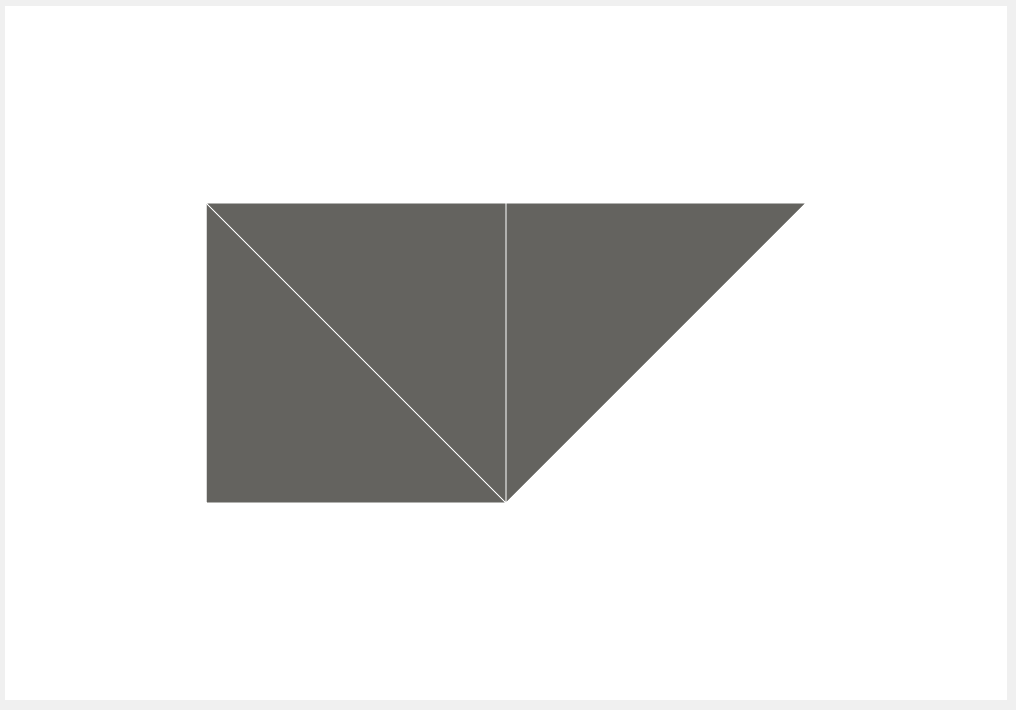

As a MeshSolution can be composed of several mesh, it is possible to set mesh.label and then call MeshSolution.plot_mesh(label="my_mesh") or the index of the mesh inside the list can be used MeshSolution.plot_mesh(index=3)

It is also possible to define groups to enable selection/plot of some part of the mesh

In [5]:
mesh_solution.group = {"square":[0,1]}  # Element 0 and 1
mesh_solution.plot_mesh(group_names="square")

None


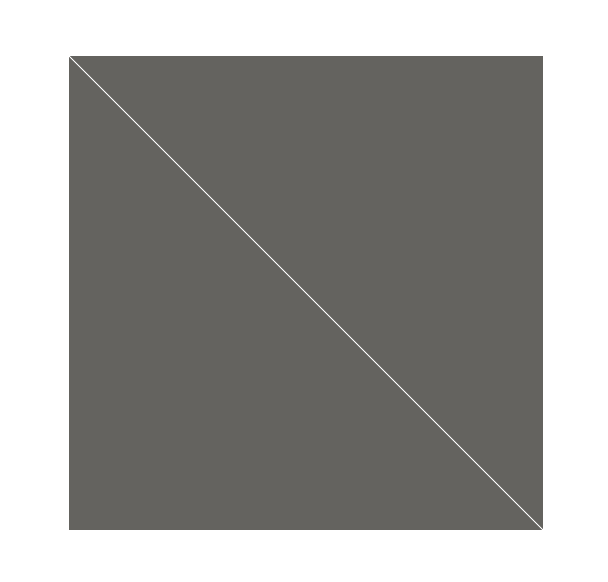

## Defining a SolutionMat object and plot
The MeshSolution object allows to make the link between data (such as FE results) and the corresponding mesh stored in a Mesh object. Thus, all the plot and post-processing methods are available in the MeshSolution class.

The main available post-processing are the plots (such as plot_contour and plot_glyph).

Here is an example with plot_contour: a scalar field is defined by giving its values for all nodes of the previous mesh. 

In [6]:
import numpy as np
from pyleecan.Classes.SolutionMat import SolutionMat

# Value the field on each node (in order)
field = np.array([[10, 11, 12, 13, 14]])
print("mesh.node.coordinate: \n"+str(mesh.node.coordinate))

my_solution = SolutionMat(
    label="my_field",
    type_element="node",  # To set the field on the nodes
    field=field,
    indice=[0, 1, 2, 3, 4],
    axis_name=["time", "indice"],
    axis_size = [1, 5],
)
# Add solution as first index
mesh_solution.solution = list()
mesh_solution.solution.append(my_solution)
mesh_solution.plot_contour()

mesh.node.coordinate: 
[[0 0 0]
 [0 1 0]
 [1 0 0]
 [1 1 0]
 [2 1 0]]


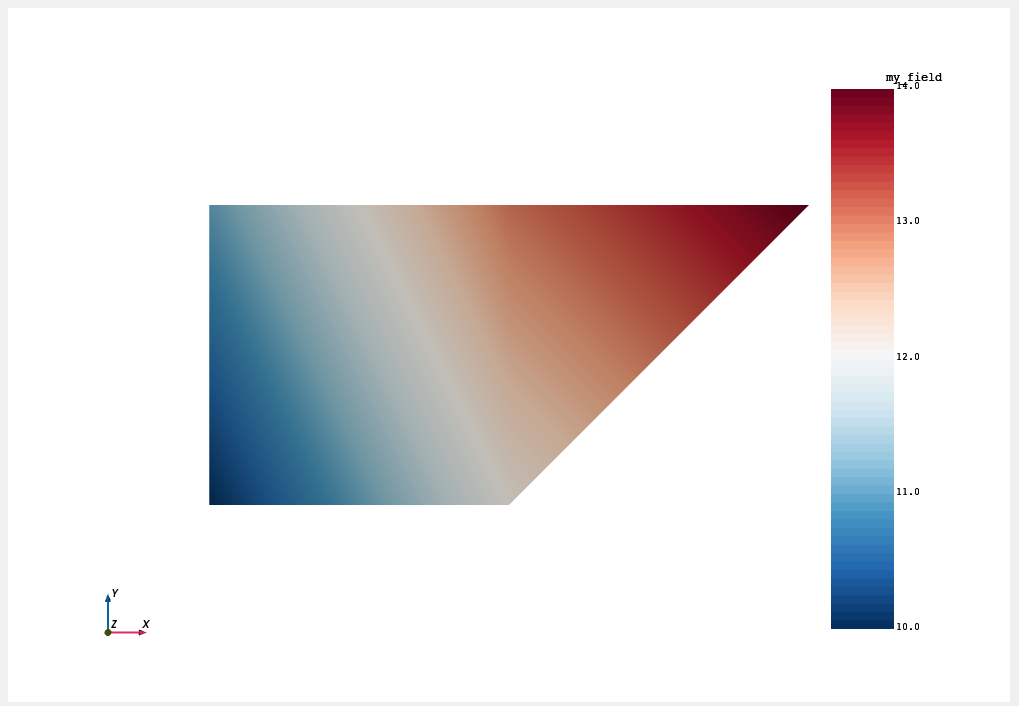

It is also possible to define a field directly on the element of the mesh

In [7]:
# Value the field on each element (in order)
field = np.array([[10, 11, 12]])

sol_element = SolutionMat(
    label="my_field",
    type_element="triangle",  # To set the field on the elements
    field=field,
    indice=[0, 1, 2],
    axis_name=["time", "indice"],
    axis_size = [1, 3],
)
# Add solution as first index
msol_element = MeshSolution(mesh=[mesh])
msol_element.solution = list()
msol_element.solution.append(sol_element)
msol_element.plot_contour()

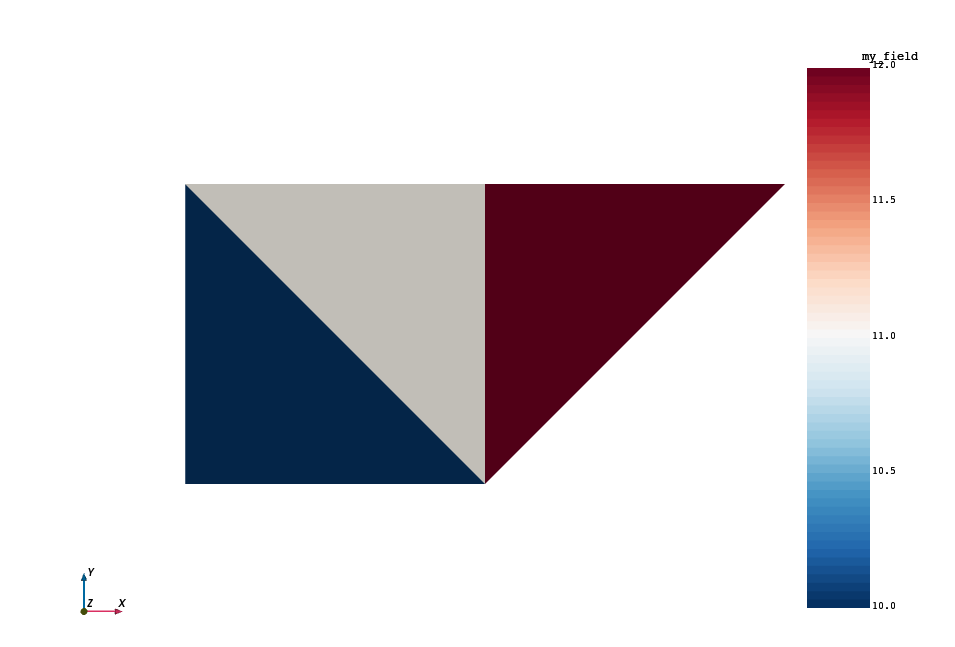

The notion of axis allows to correctly extract values as it would be with SciDataTool objects -> same way to call methods in SolutionMat/SolutionData/SolutionVector. 

Using SolutionMat, one can also defined a vector field by using an additional axis "component".

In this example, a 2D field is defined on a 3D mesh. Indeed, the mesh and the field have distinct "dimension" attributes. It enables to limit the memory space when possible. 

## Import an external Mesh

At the moment, Pyleecan mainly relies on the meshio librairy to convert any type of mesh file into a .vtk which is readable by pyvista. Any contribution on this topic is welcomed. However, we have recently added a method to import .unv files. Here is an example with a [3D mesh available on pyleecan's Github](https://github.com/Eomys/pyleecan/blob/master/Tests/Data/Mesh/mesh_test_mixte.unv)

In [8]:
#Convert to vtk with meshio
from pyleecan.definitions import TEST_DIR
from pyleecan.Classes.ImportMeshMat import ImportMeshMat
import meshio
from os.path import join
test_obj = ImportMeshMat(
    file_path=join(TEST_DIR, join(TEST_DIR, 'Data/Mesh/mesh_test_mixte.unv')),
)
mesh = test_obj.get_data()
    
# Import in Pyleecan with MeshVTK
mesh_solution2 = MeshSolution(mesh=[mesh])
mesh_solution2.plot_mesh()

None


D:\Git\pyleecan\.venvpyleecan\lib\site-packages\pyvistaqt\utils.py:40: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("gui qt")


<pyvistaqt.plotting.BackgroundPlotter(0x1e57e1ee9d0) at 0x000001E5794B5780>

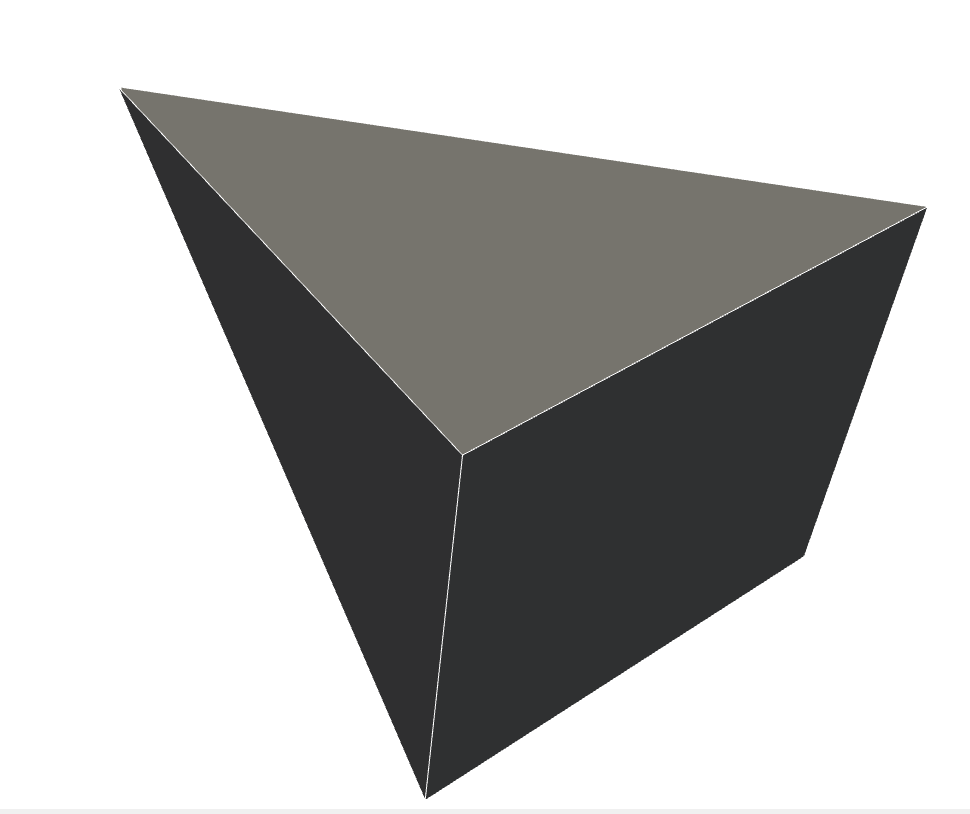

# Demo with FEMM results
The aim of this section is to show how MeshSolution object are used in Pyleecan to post-process FE results. 

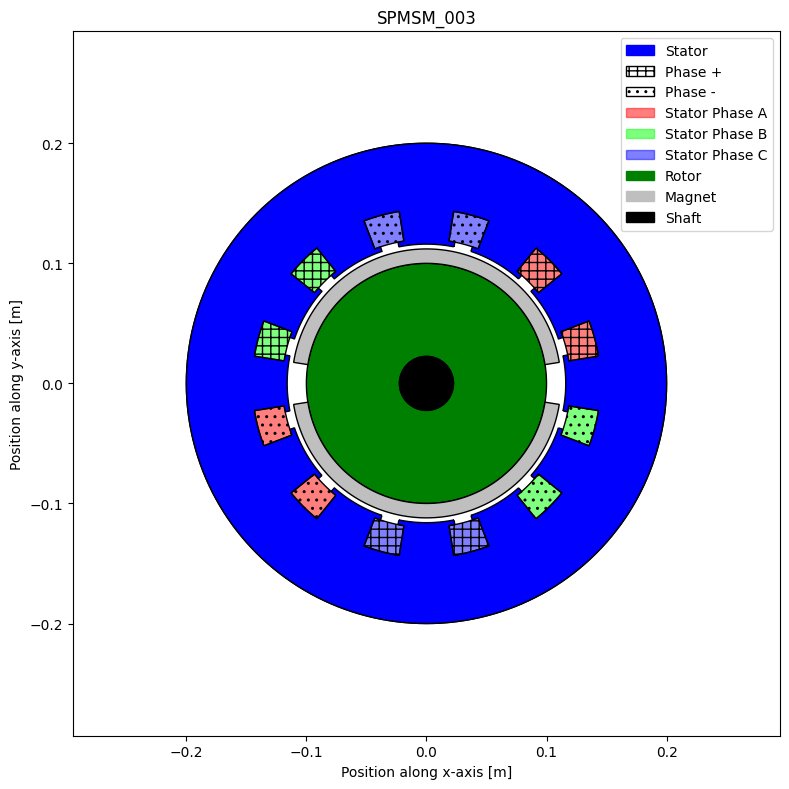

In [11]:
%matplotlib inline
# Run the FEMM simulation such as in tuto_Simulation_FEMM
import json
from multiprocessing import cpu_count
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import pytest
from numpy import array, ones, pi, zeros
from pyleecan.Classes.ImportGenVectLin import ImportGenVectLin
from pyleecan.Classes.ImportMatrixVal import ImportMatrixVal
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.Output import Output
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.definitions import DATA_DIR
from pyleecan.Functions.load import load
from Tests import save_load_path, save_plot_path

SPMSM_003 = load(join(DATA_DIR, "Machine", "SPMSM_003.json"))

simu = Simu1(name="test_SIPMSM_003", machine=SPMSM_003)
Nt_tot = 4
# Single Operating Point simulation
simu.input = InputCurrent(
    OP=OPdq(N0=3000, Id_ref=0, Iq_ref=-184),
    Nt_tot=Nt_tot,  # Nb of time step
    Na_tot=1024,  # Angular discretization
)

SPMSM_003.plot();

In [12]:
# Definition of the magnetic simulation
simu.mag = MagFEMM(
    type_BH_stator=1,
    type_BH_rotor=1,
    is_periodicity_a=True,
    is_periodicity_t=False,
    is_get_meshsolution=True,  # To save the mesh from FEMM in the output
    nb_worker=cpu_count(),
)
out_femm = simu.run()

[14:44:55] Starting running simulation test_SIPMSM_003 (machine=SPMSM_003)
[14:44:55] Starting Magnetic module
[14:44:57] Computing Airgap Flux in FEMM
[14:45:01] End of simulation test_SIPMSM_003


Now, the magnetic FEA results can be plotted. Moreover, the solution can be extracted on a specific area. By default, the field is plotted on the first dimension of every additional axis (e.g. time).

In [13]:
mesh_sol_femm = out_femm.mag.meshsolution
print("Only one mesh with sliding band: len(MS_FEMM.mesh)="+str(len(mesh_sol_femm.mesh))) 
print("The machine mesh is automatically split in several groups:")
for key in mesh_sol_femm.group.keys():
    print("- "+key)

mesh_sol_femm.plot_mesh()

mesh_sol_femm.plot_mesh(group_names=["stator core", "rotor core"])


Only one mesh with sliding band: len(MS_FEMM.mesh)=1
The machine mesh is automatically split in several groups:
- airgap
- stator core
- stator winding
- stator slot isthmus
- rotor core
- rotor magnets_0
- rotor magnets
None


None


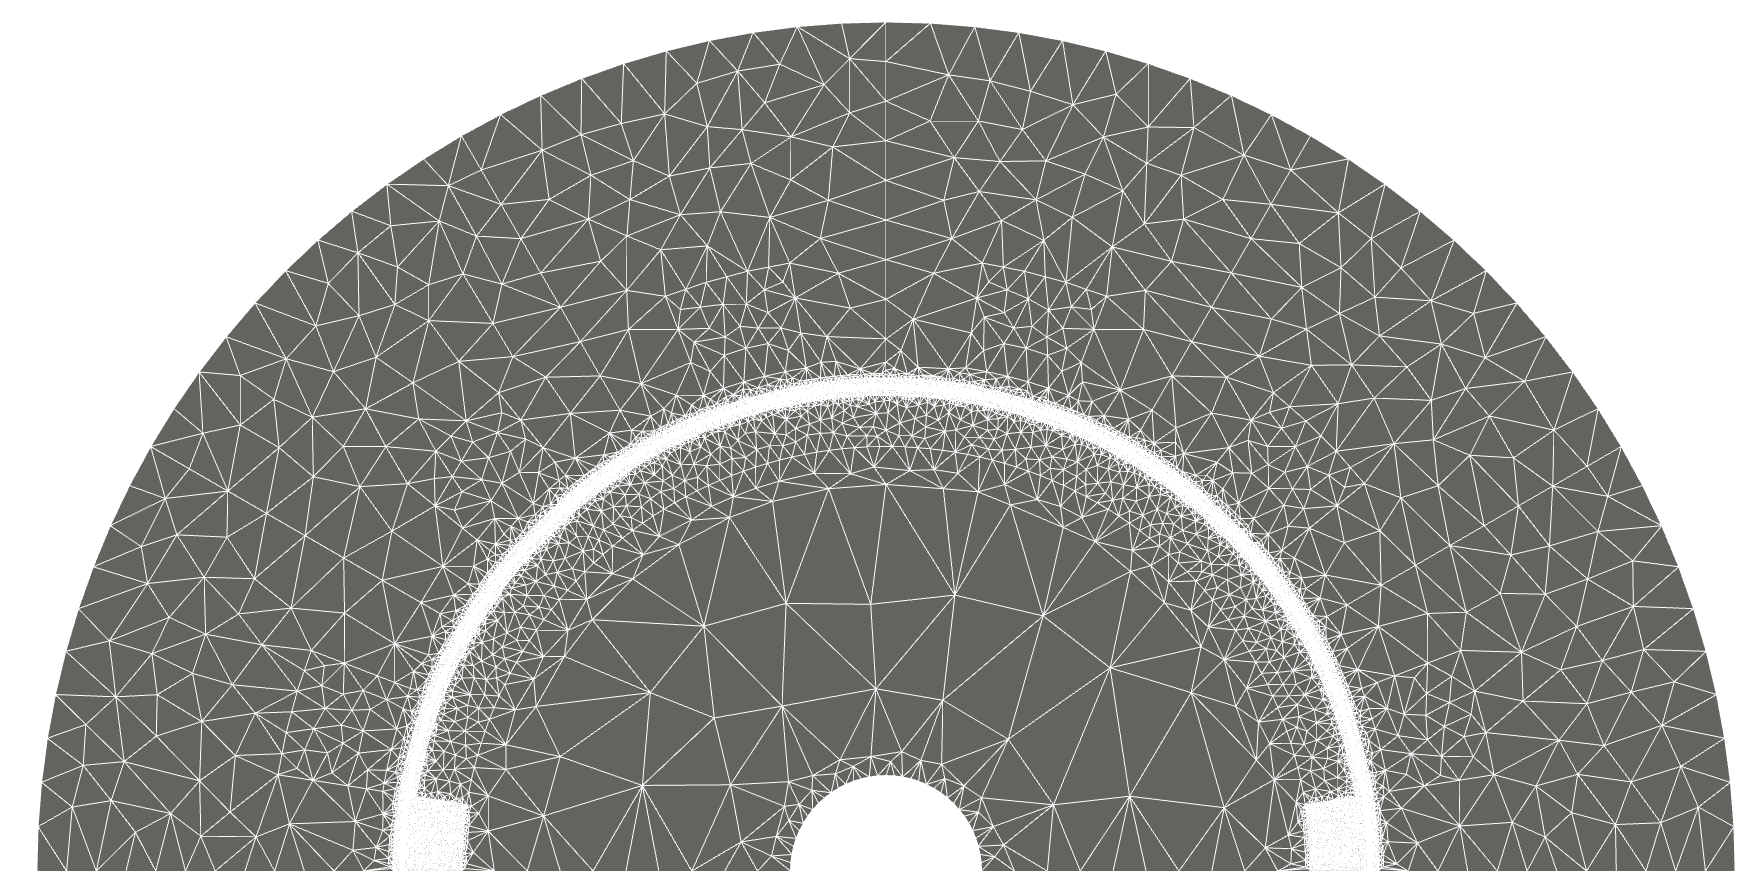
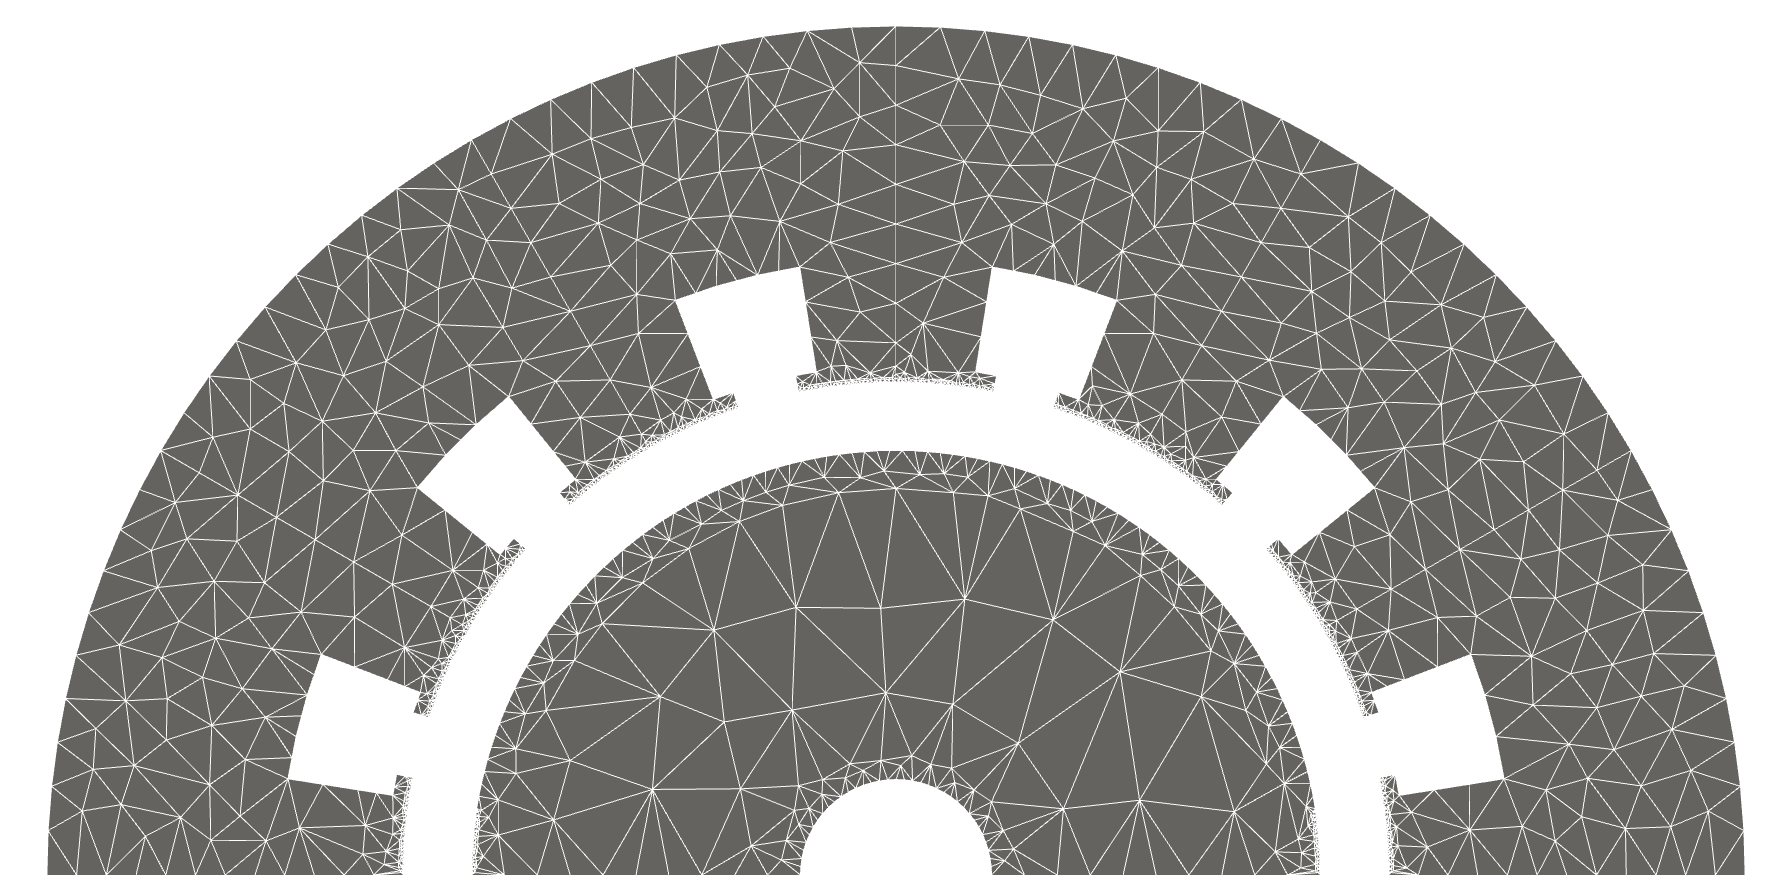

In [14]:
print("Total number of nodes: "+str(mesh_sol_femm.mesh[0].node.nb_node))
print("Only one kind of element: "+str(list(mesh_sol_femm.mesh[0].element.keys())))
print("Total number of triangle element: "+str(mesh_sol_femm.mesh[0].element["triangle"].nb_element))

Total number of nodes: 12235
Only one kind of element: ['triangle']
Total number of triangle element: 22450


In [16]:
# Sub MeshSolution can be extracted with
sub_mesh_solution = mesh_sol_femm.get_group(group_names=["stator core"])
print("Number of triangle in stator core: "+str(sub_mesh_solution.mesh[0].element["triangle"].nb_element))
sub_mesh_solution.plot_mesh()

Number of triangle in stator core: 2421
None


<pyvistaqt.plotting.BackgroundPlotter(0x1e57ddabe30) at 0x000001E507AD2340>

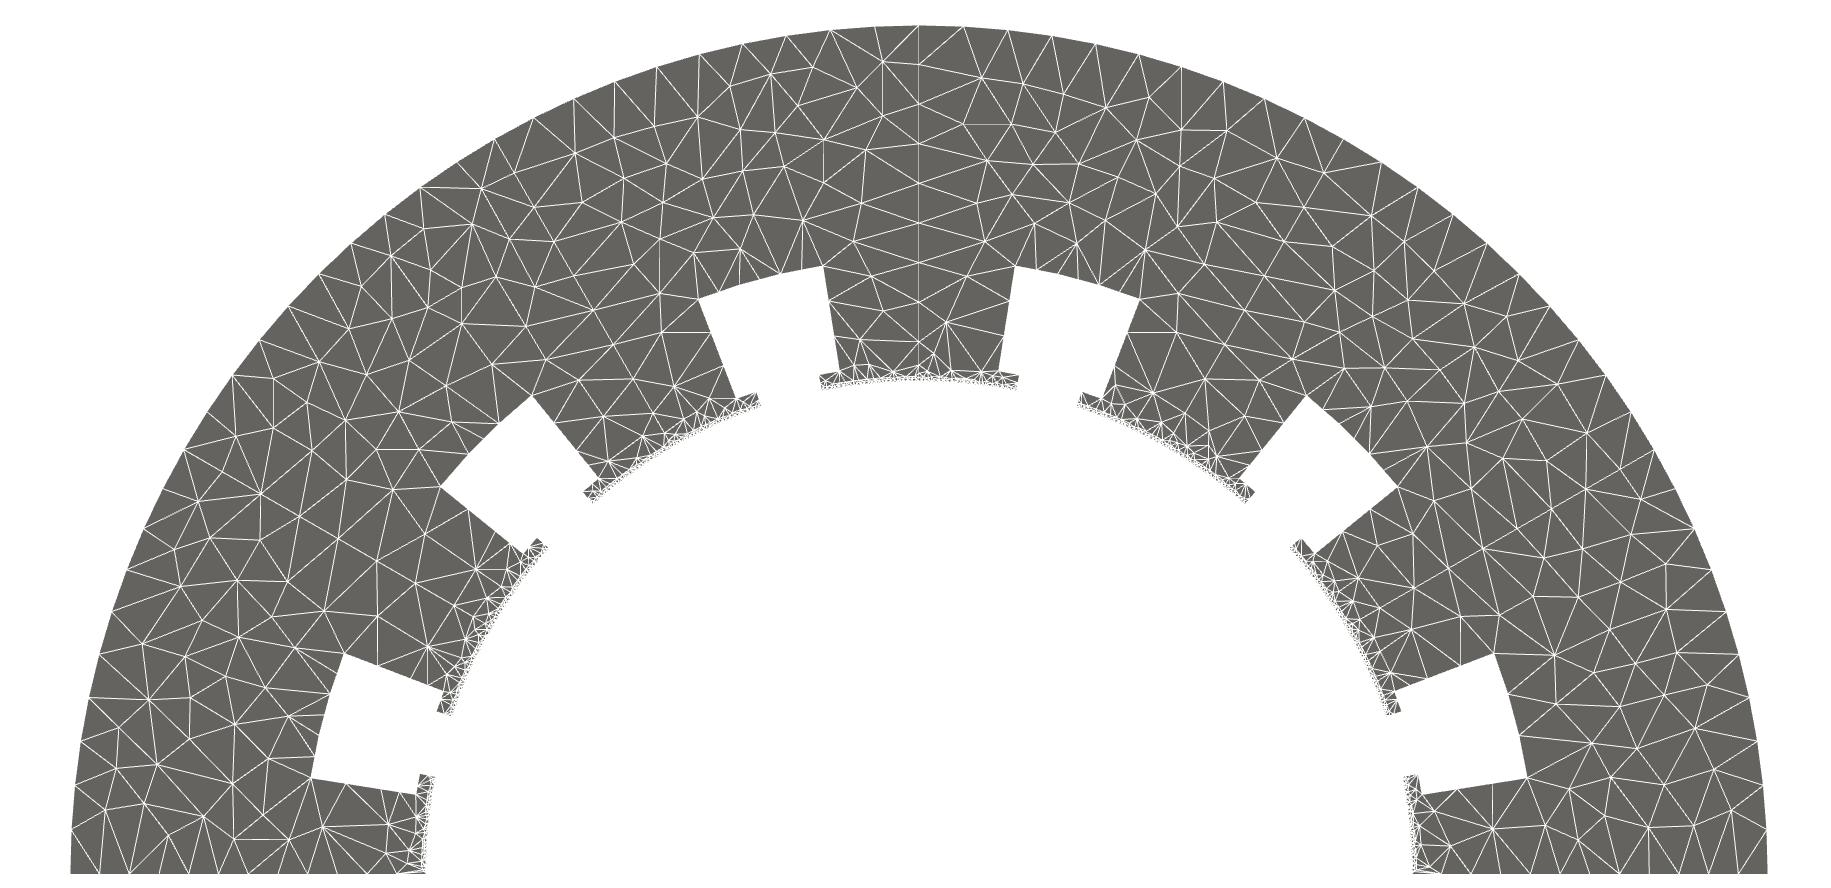

In [18]:
print("pyleecan automatically store the following quantity from FEMM:")
for sol in MS_FEMM.solution:
    print("- "+sol.label +" (on "+sol.type_cell+") " +type(sol).__name__)

pyleecan automatically store the following quantity from FEMM:
- B (on triangle)<class 'pyleecan.Classes.SolutionVector.SolutionVector'>
- H (on triangle)<class 'pyleecan.Classes.SolutionVector.SolutionVector'>
- \mu (on triangle)<class 'pyleecan.Classes.SolutionData.SolutionData'>
- A_z (on node)<class 'pyleecan.Classes.SolutionData.SolutionData'>
- A_z^{element} (on triangle)<class 'pyleecan.Classes.SolutionData.SolutionData'>


In [19]:
# Will plot the first solution on the first (and only) mesh
mesh_sol_femm.plot_contour(clim=[0,4])  # clim argument enforce the colormap limit for the plot
print(mesh_sol_femm.solution[0].label)

B


D:\Git\pyleecan\.venvpyleecan\lib\site-packages\vtkmodules\util\numpy_support.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _vtk_np = {vtkConstants.VTK_BIT:numpy.bool,


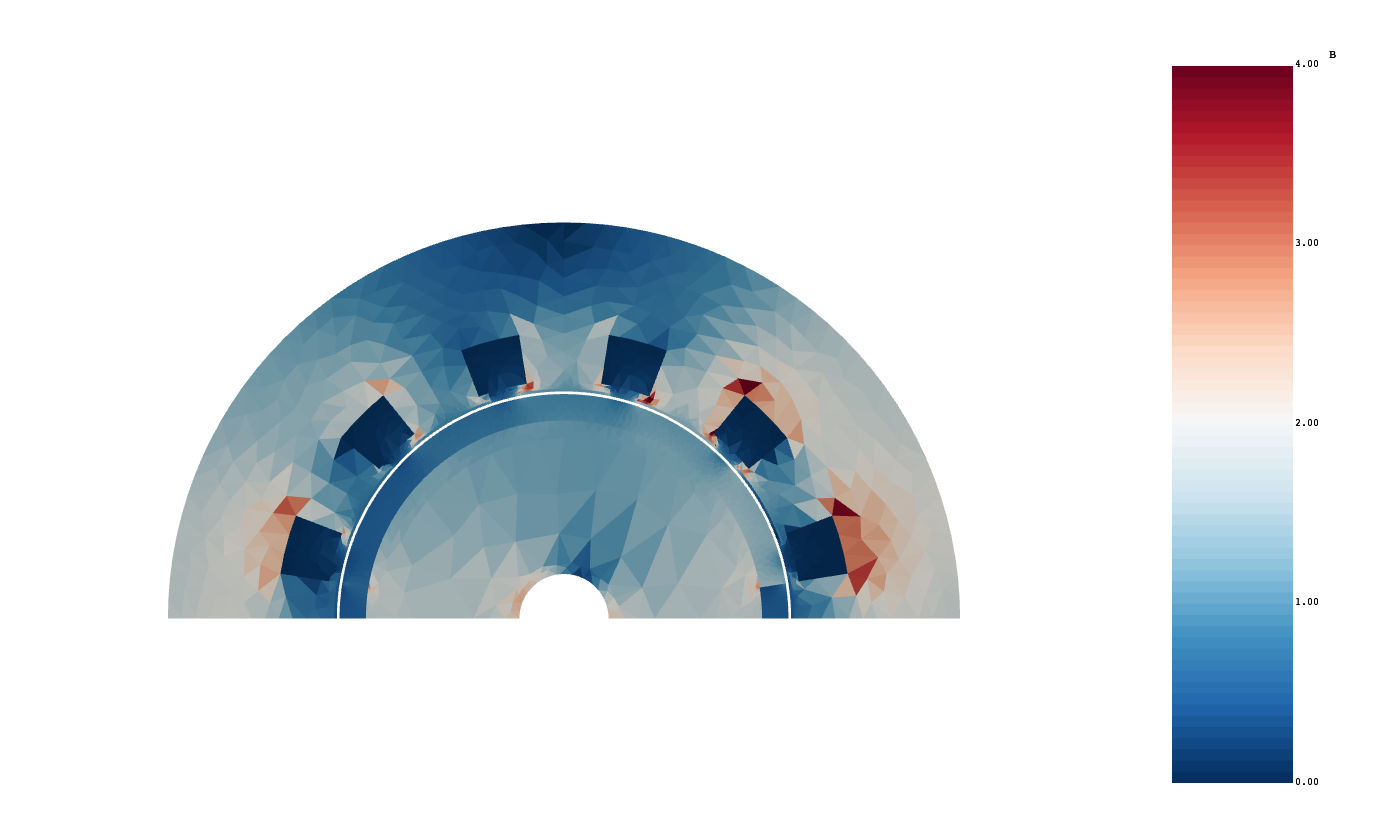

In [20]:
# It is also possible to select a solution by its label and sub-mesh with group names
mesh_sol_femm.plot_contour(label="H", group_names="stator core", clim=[0,2e3])
mesh_sol_femm.plot_contour(label="H", group_names=["stator core", "stator winding"], clim=[0,2e5])

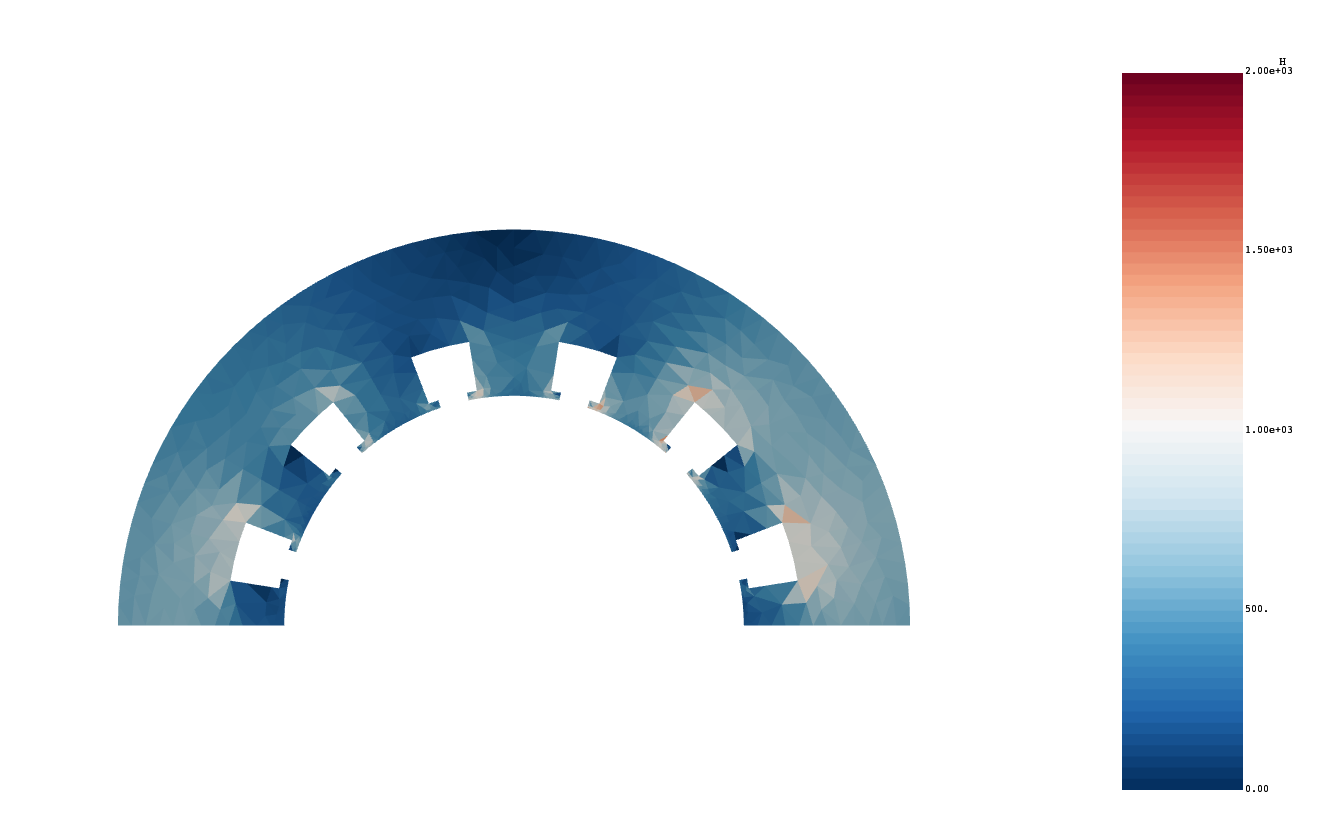
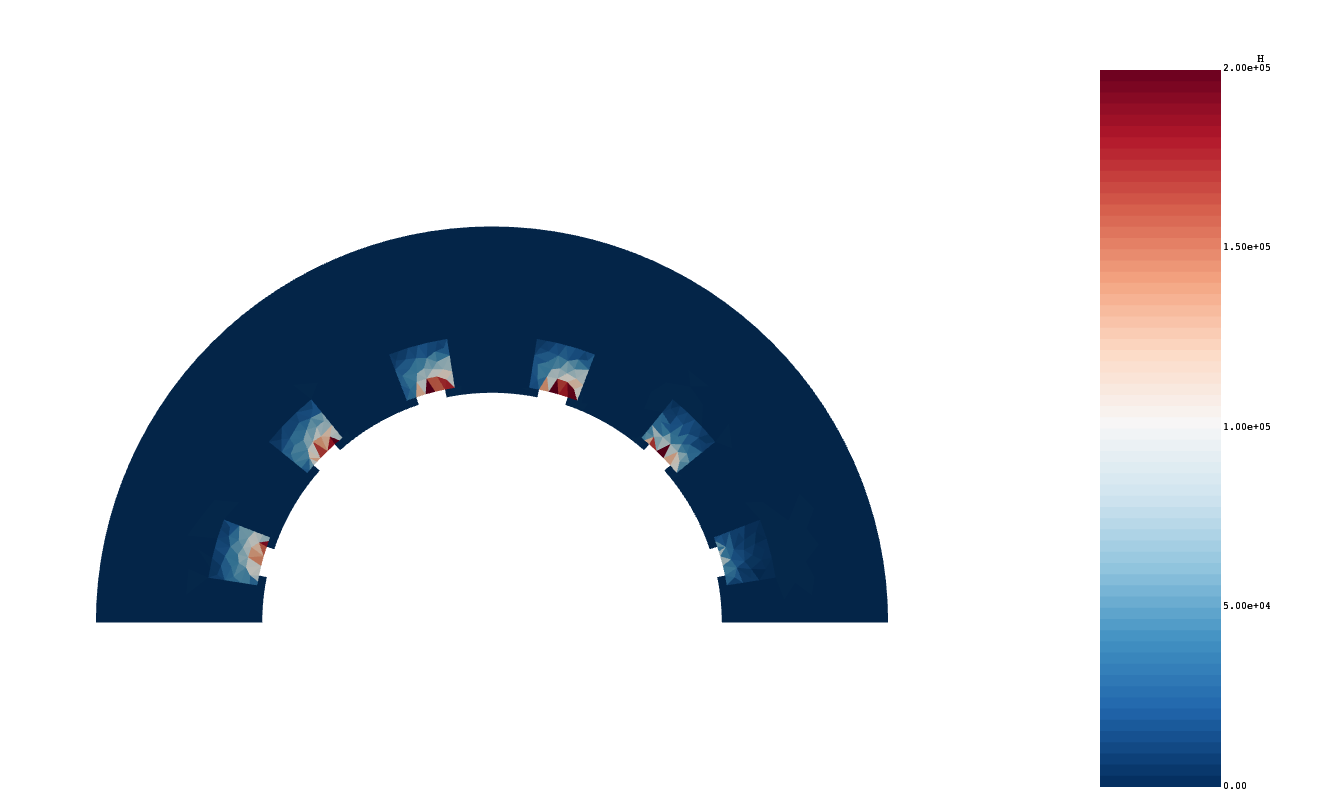

In [21]:
mesh_sol_femm.plot_glyph(label="H", group_names="stator core", factor=5e-3)

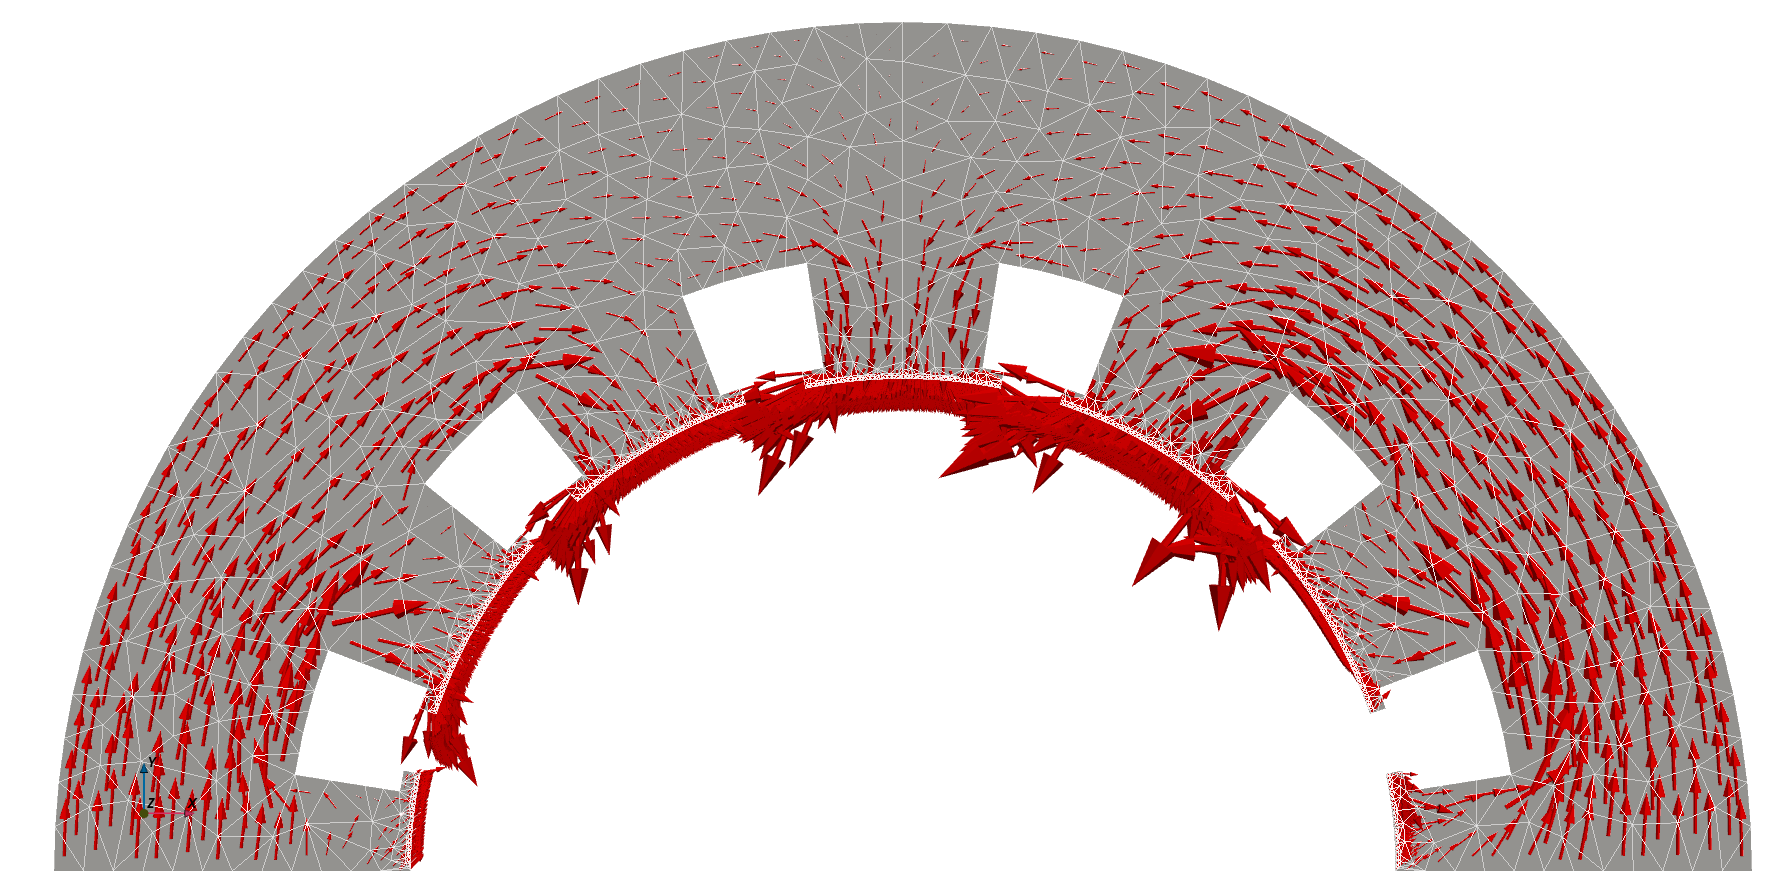

In [22]:
mesh_sol_femm.plot_contour(label="B", group_names="airgap", clim=[0,2])

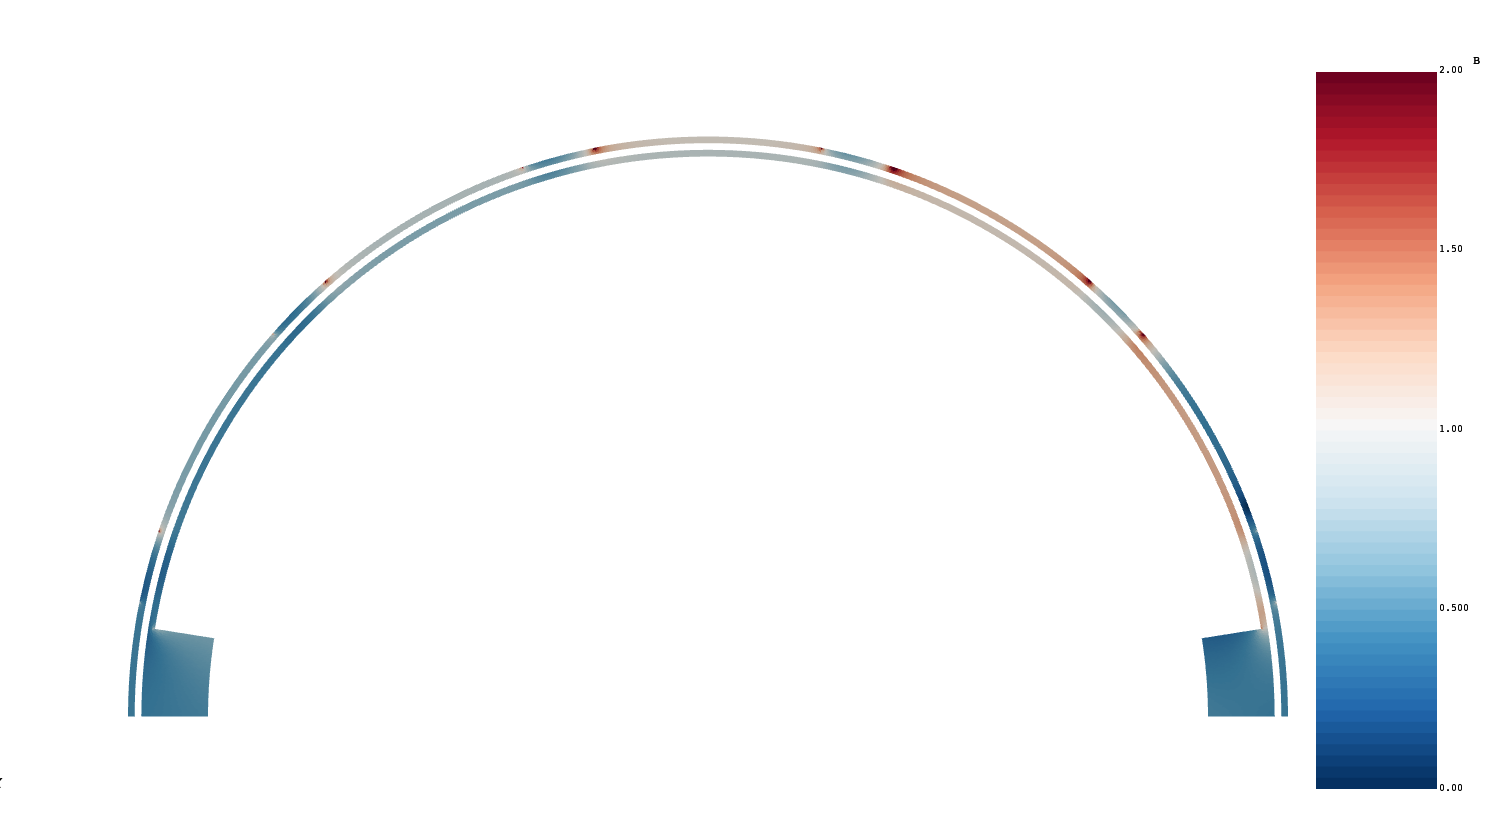

The algorithm is even capable of extracting the interface between two groups:

In [24]:
# Request interface between Stator core and (airgap + stator winding)
mesh_sol_femm.plot_mesh(group_names=["stator core", "/", "airgap", "stator winding"])

None


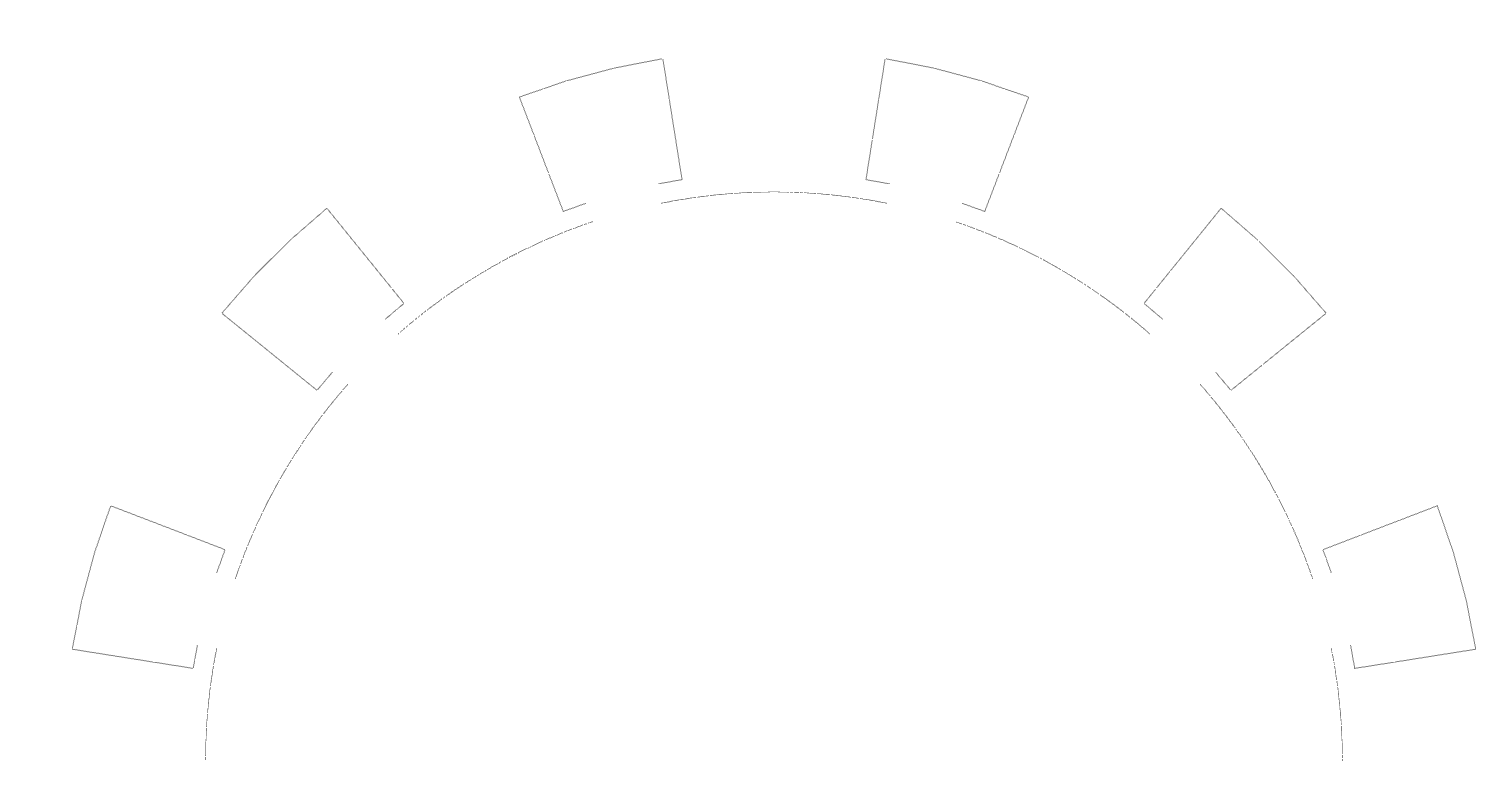
In this example, the airgap is defined as circular on the stator side, this is why there is no "slot opening" linking the interfaces

Slices through addtional axes can be obtained using [SciDataTool](https://github.com/Eomys/SciDataTool) alike call. For example, if I want the magnetic field at the second time step:

In [25]:
print(type(MS_FEMM.solution[0]))
MS_FEMM.plot_contour(
    "time[2]",
    label="H",
    # save_path=join(save_plot_path, simu.name + "_H_time2.png"),
    is_show_fig=True,
)

<class 'pyleecan.Classes.SolutionVector.SolutionVector'>


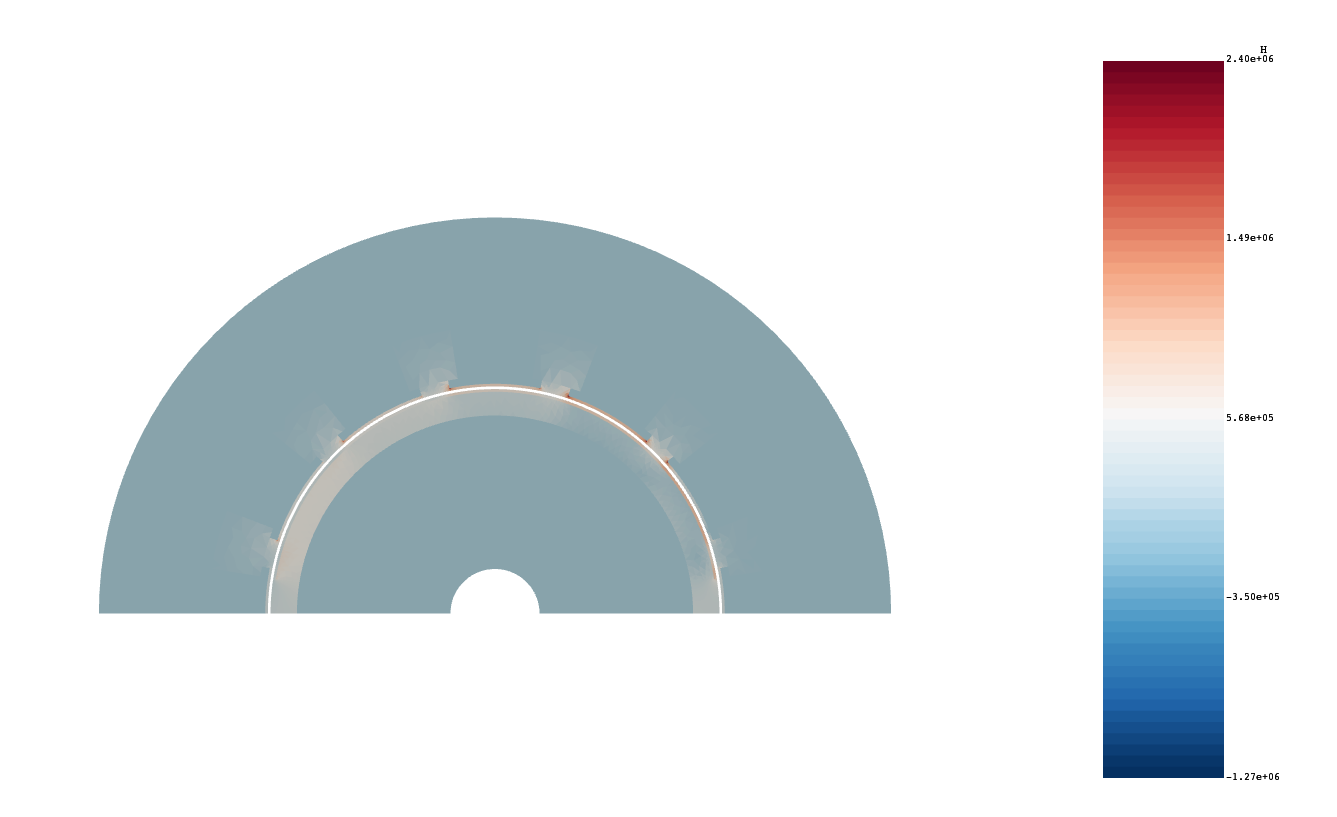

# Extract and post-process data

Several methods have been developed for the MeshSolution class in order to load the results regardless of the type of objects. The main method of MeshSolution is get_field. The first arguments can be written similarly to [SciDataTool](https://github.com/Eomys/SciDataTool) call. For example if I want to get the magnetic flux density at the first time step after FEMM calculations:

In [26]:
B = mesh_sol_femm.get_field("time[0]", "indice", "component", label='B')
print(B.shape)

(22450, 2)


Another useful feature is the groups. The groups allows to define submeshes corresponding to subpart of the machine. A new MeshSolution object can be created from the group definition:

In [27]:
group_stator = mesh_sol_femm.get_group("stator core")
N_element_stator = group_stator.mesh[0].element["triangle"].nb_element
print("Number of triangle in stator core: "+str(N_element_stator))
group_stator.plot_mesh()

Number of triangle in stator core: 2421
None


<pyvistaqt.plotting.BackgroundPlotter(0x1e5225b5240) at 0x000001E510559C40>

Then, the magnetic solution is filtered on the selected elements (triangular elements in this case). 

In [28]:
import numpy as np

print(out_femm.mag.meshsolution.solution[0].label)
print(out_femm.mag.meshsolution.solution[0].field.components.keys())

group_magnets = out_femm.mag.meshsolution.get_group("rotor magnets_0")
B_s = group_magnets.get_field("indice", "time", "component", label='B')
H_s = group_magnets.get_field("indice", "time", "component", label='H')
print(B_s.shape)  # (Nt_tot, N cell, x/y component)
print(H_s.shape)  # (Nt_tot, N cell, x/y component)

Node_id = 400
B_s_abs = np.sqrt(B_s[:,Node_id,0]**2 + B_s[:,Node_id,1]**2)
H_s_abs = np.sqrt(H_s[:,Node_id,0]**2 + H_s[:,Node_id,1]**2)
print(B_s_abs.shape)
print(H_s_abs.shape)
plt.scatter(H_s_abs,B_s_abs)

(4, 2421, 2)
(4, 2421, 2)


The dimension of the field has been obviously reduced to the stator number of elements. Then, operations can be performed on the solution of this group, and plotted. It is worth noting that several type of Solution objects can co-exist in the same MeshSolution object.

In [29]:
from pyleecan.Classes.SolutionMat import SolutionMat
w_mag = np.multiply(B_s,H_s)/2

my_vec_solution = SolutionMat(
    label="w_mag",
    type_element="triangle",
    field=w_mag,
    axis_name=["time", "indice", "component"],
    axis_size = [Nt_tot, N_element_stator, 2],
)
group_stator.solution.append(my_vec_solution)
group_stator.plot_contour(label="w_mag")

Operations can also be performed on the mesh.

In [30]:
nodes_s = group_stator.get_mesh().get_node_coordinate()
print(nodes_s.shape)  # (Nnodes, 2 dimensions)

(1663, 2)


Then, rotate the mesh

In [31]:
th = np.pi/2
R = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])
nodes_s = np.dot(nodes_s, R)
group_stator.mesh[0].node.coordinate = nodes_s
group_stator.plot_mesh()

None


<pyvistaqt.plotting.BackgroundPlotter(0x1e51da61de0) at 0x000001E50D576C00>

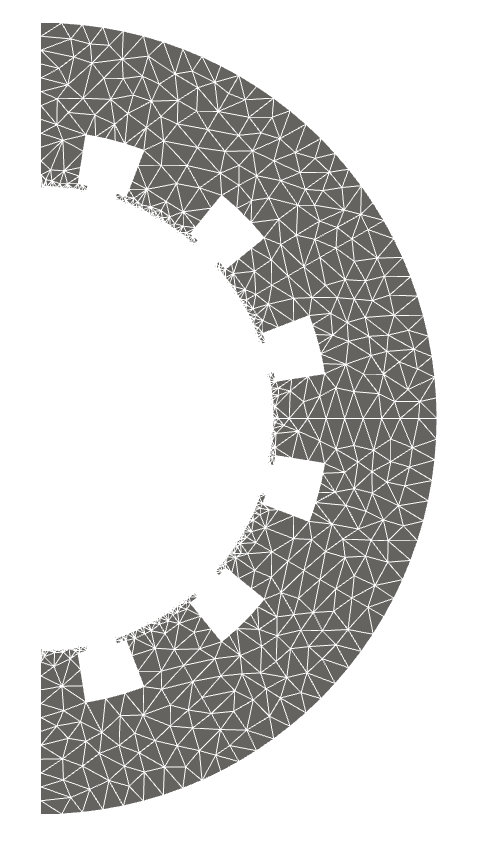
Previous plots still work ! (since the link solution to mesh is made thought the indices of the nodes)

In [32]:
group_stator.plot_contour(label="w_mag")

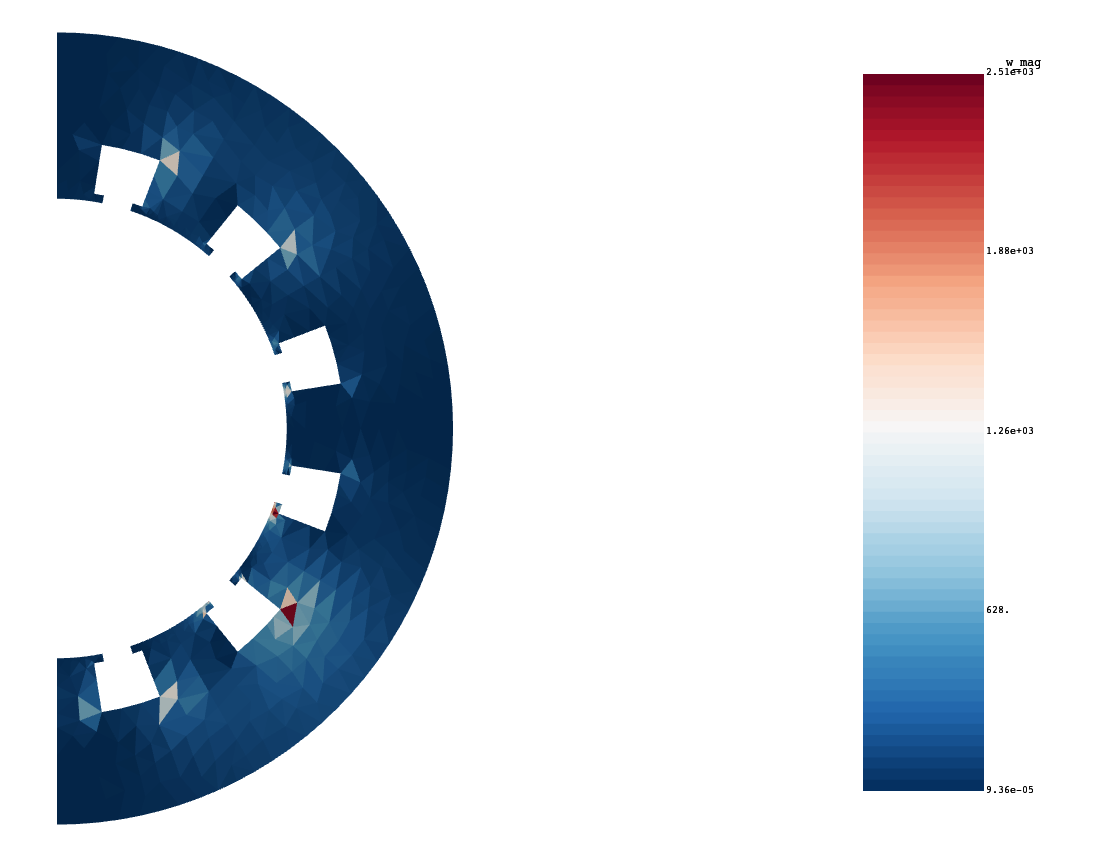
Thanks for following this tutorial ! :-)